In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from math import floor
import time
from sklearn.model_selection import train_test_split
from sklearn import model_selection
# from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
import sklearn.linear_model as lm
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import  metrics
import warnings
warnings.filterwarnings('ignore')

C:\Users\Edyta\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Wczytanie i poznanie danych, które będą przedmiotem analizy

Wczytanie danych z pliku do obiektu Data Frame.

In [2]:
df = pd.read_csv('./data/ames2000_NAfix.csv')
df.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,...,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,RL,34,3901,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,8,2007,New,Partial,204000
1,20,RL,70,8400,Pave,None,Reg,Lvl,AllPub,Corner,...,0,None,MnPrv,None,0,4,2010,WD,Normal,126000
2,85,RL,60,7200,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,MnPrv,None,0,4,2009,WD,Normal,133900
3,90,RL,64,7018,Pave,None,Reg,Bnk,AllPub,Inside,...,0,None,None,None,0,6,2009,WD,Alloca,118858
4,60,RL,111,16259,Pave,None,Reg,Lvl,AllPub,Corner,...,0,None,None,None,0,9,2006,New,Partial,342643


In [3]:
df.shape

(2000, 80)

Ponieważ domyślnie obiekt Data Frame pokazuje tylko niektóre początkowe i końcowe kolumny, zwiększam parametry max_colums, max_rows co pozwoli przegląd pełnego zakresu danych, także po transpozycji.

In [4]:
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 80)

In [5]:
df.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,RL,34,3901,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,Twnhs,1Story,6,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,Stone,182,Gd,TA,PConc,Gd,TA,Av,ALQ,866,Unf,0,436,1302,GasA,Ex,Y,SBrkr,1302,0,0,1302,1,0,1,1,1,1,Gd,5,Typ,1,Gd,Attchd,2005,RFn,2,631,TA,TA,Y,110,50,0,0,0,0,None,None,None,0,8,2007,New,Partial,204000
1,20,RL,70,8400,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Nonemes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,CBlock,TA,TA,No,ALQ,804,Rec,78,0,882,GasA,TA,Y,SBrkr,882,0,0,882,1,0,1,0,2,1,TA,4,Typ,0,None,Attchd,1970,Fin,2,525,TA,TA,Y,240,0,0,0,0,0,None,MnPrv,None,0,4,2010,WD,Normal,126000
2,85,RL,60,7200,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,SFoyer,5,8,1972,2003,Gable,CompShg,WdShing,HdBoard,None,0,TA,Gd,CBlock,Gd,TA,Av,GLQ,660,Unf,0,108,768,GasA,Gd,Y,SBrkr,768,0,0,768,0,1,1,0,2,1,TA,5,Typ,0,None,Detchd,1974,Fin,1,396,TA,TA,Y,192,0,0,0,0,0,None,MnPrv,None,0,4,2009,WD,Normal,133900
3,90,RL,64,7018,Pave,None,Reg,Bnk,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Duplex,1Story,5,5,1979,1979,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,Slab,None,None,None,None,0,None,0,0,0,GasA,TA,Y,SBrkr,1535,0,0,1535,0,0,2,0,4,2,TA,8,Typ,0,None,Attchd,1979,Unf,2,400,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,6,2009,WD,Alloca,118858
4,60,RL,111,16259,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,Stone,370,TA,TA,PConc,Ex,Gd,Av,Unf,0,Unf,0,1249,1249,GasA,Ex,Y,SBrkr,1249,1347,0,2596,0,0,3,1,4,1,Gd,9,Typ,0,None,Attchd,2006,RFn,3,840,TA,TA,Y,240,154,0,0,0,0,None,None,None,0,9,2006,New,Partial,342643


In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MS.SubClass,2000.0,56.9450,42.699281,20.0,20.00,50.0,70.00,190.0
Lot.Area,2000.0,10296.6650,8828.208491,1300.0,7500.00,9465.0,11500.00,215245.0
Overall.Qual,2000.0,6.0820,1.387169,1.0,5.00,6.0,7.00,10.0
Overall.Cond,2000.0,5.5740,1.105502,1.0,5.00,5.0,6.00,9.0
Year.Built,2000.0,1971.0795,29.985426,1872.0,1954.00,1972.0,2000.00,2010.0
Year.Remod.Add,2000.0,1984.0135,20.881771,1950.0,1965.00,1993.0,2004.00,2010.0
X1st.Flr.SF,2000.0,1158.7155,379.701015,407.0,877.75,1088.0,1391.25,4692.0
X2nd.Flr.SF,2000.0,334.3805,427.519973,0.0,0.00,0.0,703.25,2065.0
Low.Qual.Fin.SF,2000.0,4.3790,42.555738,0.0,0.00,0.0,0.00,697.0
Gr.Liv.Area,2000.0,1497.4750,498.561719,407.0,1126.75,1447.5,1734.00,5642.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 80 columns):
MS.SubClass        2000 non-null int64
MS.Zoning          2000 non-null object
Lot.Frontage       2000 non-null object
Lot.Area           2000 non-null int64
Street             2000 non-null object
Alley              2000 non-null object
Lot.Shape          2000 non-null object
Land.Contour       2000 non-null object
Utilities          2000 non-null object
Lot.Config         2000 non-null object
Land.Slope         2000 non-null object
Neighborhood       2000 non-null object
Condition.1        2000 non-null object
Condition.2        2000 non-null object
Bldg.Type          2000 non-null object
House.Style        2000 non-null object
Overall.Qual       2000 non-null int64
Overall.Cond       2000 non-null int64
Year.Built         2000 non-null int64
Year.Remod.Add     2000 non-null int64
Roof.Style         2000 non-null object
Roof.Matl          2000 non-null object
Exterior.1st       

### Kopia zapasowa danych

Przed rozpoczęciem transformacji danych tworzę kopię zapasową zbioru.

In [8]:
df_copy = df.copy()
df_copy.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition,SalePrice
0,120,RL,34,3901,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,Twnhs,1Story,6,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,Stone,182,Gd,TA,PConc,Gd,TA,Av,ALQ,866,Unf,0,436,1302,GasA,Ex,Y,SBrkr,1302,0,0,1302,1,0,1,1,1,1,Gd,5,Typ,1,Gd,Attchd,2005,RFn,2,631,TA,TA,Y,110,50,0,0,0,0,None,None,None,0,8,2007,New,Partial,204000
1,20,RL,70,8400,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Nonemes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,CBlock,TA,TA,No,ALQ,804,Rec,78,0,882,GasA,TA,Y,SBrkr,882,0,0,882,1,0,1,0,2,1,TA,4,Typ,0,None,Attchd,1970,Fin,2,525,TA,TA,Y,240,0,0,0,0,0,None,MnPrv,None,0,4,2010,WD,Normal,126000
2,85,RL,60,7200,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,SFoyer,5,8,1972,2003,Gable,CompShg,WdShing,HdBoard,None,0,TA,Gd,CBlock,Gd,TA,Av,GLQ,660,Unf,0,108,768,GasA,Gd,Y,SBrkr,768,0,0,768,0,1,1,0,2,1,TA,5,Typ,0,None,Detchd,1974,Fin,1,396,TA,TA,Y,192,0,0,0,0,0,None,MnPrv,None,0,4,2009,WD,Normal,133900
3,90,RL,64,7018,Pave,None,Reg,Bnk,AllPub,Inside,Gtl,SawyerW,Norm,Norm,Duplex,1Story,5,5,1979,1979,Gable,CompShg,Plywood,Plywood,None,0,TA,TA,Slab,None,None,None,None,0,None,0,0,0,GasA,TA,Y,SBrkr,1535,0,0,1535,0,0,2,0,4,2,TA,8,Typ,0,None,Attchd,1979,Unf,2,400,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,6,2009,WD,Alloca,118858
4,60,RL,111,16259,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,Stone,370,TA,TA,PConc,Ex,Gd,Av,Unf,0,Unf,0,1249,1249,GasA,Ex,Y,SBrkr,1249,1347,0,2596,0,0,3,1,4,1,Gd,9,Typ,0,None,Attchd,2006,RFn,3,840,TA,TA,Y,240,154,0,0,0,0,None,None,None,0,9,2006,New,Partial,342643


### Oczyszczanie danych - usuwanie braków oraz wartości null

W pierwszej kolejności sprawdzam, w których kolumnach występują wartości null, czyli 'NaN'.

In [9]:
def containsNulls(df):
    contains_nulls = df.columns[df.isna().any() == True]
    return contains_nulls

In [10]:
contains_nulls = containsNulls(df)
contains_nulls

Index(['Mas.Vnr.Type', 'Bsmt.Qual', 'Bsmt.Cond', 'Bsmt.Exposure',
       'BsmtFin.Type.1', 'BsmtFin.Type.2', 'Garage.Finish', 'Garage.Qual',
       'Garage.Cond'],
      dtype='object')

In [11]:
# def missing_data(data):
#     return len(data) - data.count()

# nulls_numbers = missing_data(df)[missing_data(df) != 0]
# print(nulls_numbers.sort_values(ascending=False))

Istnieje 9 kolumn zawierających wartości null. Braki dotyczą cech piwnicy i garażu oraz forniru murarskiego. W kolejnym kroku sprawdzam jakie są unikalne wartości dla tych kolumn.

In [12]:
def uniqueValuesInContainsNulls(df, list):
    for item in list:
        print(item, ':', df[item].unique())

In [13]:
uniqueValuesInContainsNulls(df, contains_nulls)

Mas.Vnr.Type : ['Stone' 'None' 'BrkFace' nan 'BrkCmn' 'CBlock']
Bsmt.Qual : ['Gd' 'TA' 'None' 'Ex' 'Fa' nan 'Po']
Bsmt.Cond : ['TA' 'None' 'Gd' 'Fa' 'Ex' nan 'Po']
Bsmt.Exposure : ['Av' 'No' 'None' 'Gd' 'Mn' nan]
BsmtFin.Type.1 : ['ALQ' 'GLQ' 'None' 'Unf' 'LwQ' 'Rec' 'BLQ' nan]
BsmtFin.Type.2 : ['Unf' 'Rec' 'None' 'GLQ' 'ALQ' 'LwQ' 'BLQ' nan]
Garage.Finish : ['RFn' 'Fin' 'Unf' 'None' nan]
Garage.Qual : ['TA' 'None' 'Fa' 'Gd' nan 'Po' 'Ex']
Garage.Cond : ['TA' 'None' 'Gd' 'Fa' 'Po' nan 'Ex']


Po analizie list wartości dla poszczególnych pól przyjmuję założenie, że brak informacji oznaczać będzie brak cechy. Dlatego brakujące wartości zostaną uzupełnione wartością None.

In [14]:
def fillNullByNone(df, contains_nulls):
    for item in contains_nulls:
        df[item] = df[item].fillna('None')

In [15]:
fillNullByNone(df, contains_nulls)

Ponowne sprawdzam, czy wszystkie modyfikowane kolumny zawierają wartości różne od null.

In [16]:
df[contains_nulls].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
Mas.Vnr.Type      2000 non-null object
Bsmt.Qual         2000 non-null object
Bsmt.Cond         2000 non-null object
Bsmt.Exposure     2000 non-null object
BsmtFin.Type.1    2000 non-null object
BsmtFin.Type.2    2000 non-null object
Garage.Finish     2000 non-null object
Garage.Qual       2000 non-null object
Garage.Cond       2000 non-null object
dtypes: object(9)
memory usage: 140.7+ KB


W zbiorze obecnie brak już wartości null. Sprawdzam liczbę unikalnych wartości dla każdej z kolumn.

In [17]:
def dfTypesAndUniques(df):
    types = df.dtypes
    nunique = df.nunique()
    df_info = pd.DataFrame(pd.concat([types, nunique], axis =1))
    df_info = df_info.rename(columns={0:'Type', 1:'Num_unique'}).sort_values(by='Num_unique', ascending=False)
    return df_info

In [18]:
df_info = dfTypesAndUniques(df)
df_info

,Type,Num_unique
Lot.Area,int64,1424
Gr.Liv.Area,int64,1051
Bsmt.Unf.SF,object,928
X1st.Flr.SF,int64,902
Total.Bsmt.SF,object,871
BsmtFin.SF.1,object,817
SalePrice,int64,812
Garage.Area,object,531
X2nd.Flr.SF,int64,500
Mas.Vnr.Area,object,363


Rozdzielam dane numeryczne od tekstowych. 

In [19]:
def numericAndTextData(df_info):
    df_numeric = df_info[df_info['Type'] == 'int64']
    df_text = df_info[df_info['Type'] == 'object']
    print(f'Amount of numeric data: {len(df_numeric)}, Amount of text data: {len(df_text)}')

    numeric = df_numeric.index
    text = df_text.index
    return (numeric, text)

In [20]:
numeric, text = numericAndTextData(df_info)
print(f'Numeric columns: {numeric}')
print(f'Text columns: {text}')

Amount of numeric data: 26, Amount of text data: 54
Numeric columns: Index(['Lot.Area', 'Gr.Liv.Area', 'X1st.Flr.SF', 'SalePrice', 'X2nd.Flr.SF',
       'Wood.Deck.SF', 'Open.Porch.SF', 'Enclosed.Porch', 'Year.Built',
       'Screen.Porch', 'Year.Remod.Add', 'Misc.Val', 'Low.Qual.Fin.SF',
       'X3Ssn.Porch', 'MS.SubClass', 'Mo.Sold', 'Pool.Area', 'TotRms.AbvGrd',
       'Overall.Qual', 'Overall.Cond', 'Bedroom.AbvGr', 'Fireplaces',
       'Full.Bath', 'Yr.Sold', 'Kitchen.AbvGr', 'Half.Bath'],
      dtype='object')
Text columns: Index(['Bsmt.Unf.SF', 'Total.Bsmt.SF', 'BsmtFin.SF.1', 'Garage.Area',
       'Mas.Vnr.Area', 'BsmtFin.SF.2', 'Lot.Frontage', 'Garage.Yr.Blt',
       'Neighborhood', 'Exterior.2nd', 'Exterior.1st', 'Sale.Type',
       'Condition.1', 'House.Style', 'Functional', 'Garage.Type',
       'Garage.Cars', 'MS.Zoning', 'Condition.2', 'Roof.Matl',
       'BsmtFin.Type.2', 'BsmtFin.Type.1', 'Heating', 'Roof.Style',
       'Garage.Cond', 'Bsmt.Cond', 'Bsmt.Qual', 'Fireplac

Sprawdzam, czy wśród kolumn tekstowych znajdują się podejrzane kolumny, zawierające po kilkaset unikalnych wartości. Należy im się przyjrzeć bliżej.

In [21]:
def checkTextValues(df, text_columns_list):
    for item in text_columns_list:
        print(item, ':', df[item].unique())

In [22]:
checkTextValues(df, text)

Bsmt.Unf.SF : ['436' '0' '108' '1249' '560' '576' '125' '634' '912' '894' '305' '869'
 '970' '636' '1836' '195' '497' '526' '726' '1615' '100' '768' '253' '94'
 '398' '1028' '440' '34' '331' '240' '860' '210' '466' '589' '286' '994'
 '918' '1348' '434' '715' '140' '384' '794' '1459' '99' '354' '127' '244'
 '1696' '1264' '704' '201' '686' '662' '1141' '455' '1005' '1632' '252'
 '1421' '171' '1541' '1580' '460' '268' '169' '896' '938' '1420' '960'
 '903' '849' '307' '237' '162' '1686' '130' '399' '1181' '784' '414'
 '1280' '564' '115' '1008' '92' '710' '917' '1560' '1040' '585' '52' '386'
 '491' '1286' '200' '1026' '534' '1228' '144' '728' '675' '238' '480'
 '160' '1242' '1088' '884' '458' '637' '182' '278' '578' '355' '280' '300'
 '413' '756' '746' '658' '724' '544' '103' '1680' '880' '712' '1357' '161'
 '325' '378' '176' '750' '245' '290' '808' '522' '133' '664' '192' '672'
 '939' '132' '731' '113' '1528' '308' '625' '484' '223' '1694' '28' '718'
 '476' '415' '770' '420' '630' '126' '8

Okazuje się, że wśród danych tekstowych znalazły się także kolumny zawierające tak naprawdę dane numeryczne, ale także wartość 'None'. 
W przypadku kolumn 'Bsmt.Unf.SF', 'Total.Bsmt.SF', 'BsmtFin.SF.1', 'Garage.Area', 'Mas.Vnr.Area', 'BsmtFin.SF.2', cechy garażu i piwnicy z wartością 'None' zostaną zastąpione wartością 0. Dane w wymienionych kolumnach są podawane w jednostce SF (stopy kwadratowe), dlatego zamiana na zero nie wpłynie na interpretację danych.

Po zamianie wartości, zmieniony zostanie także typ kolumny na int64. Krok jest niezbędny do kolejnego etapu - wytrenowania modelu. 

In [23]:
def changeNoneToZeroForAreasData(df, lst):
    for item in lst:
        df.loc[df[item][df[item] == 'None'].index, item ] = 0
        df[item] = df[item].astype('int64')
    return

In [24]:
lst_zero = ['Bsmt.Unf.SF', 'Total.Bsmt.SF', 'BsmtFin.SF.1', 'Garage.Area', 'Mas.Vnr.Area', 'BsmtFin.SF.2']
changeNoneToZeroForAreasData(df, lst_zero)

Kolumna 'Lot.Frontage' oznacza liczbę stóp od ulicy, nie można zatem wstawić zera, gdyż żaden dom nie może stać na krawędzi ulicy. W celu uzupełnienia danych zostanie wstawiona średnia liczba stóp od ulicy, wyliczona z danych pozostałych domów. Następnie typ danych również zostanie zamieniony na typ int64.

In [25]:
def changeNoneToMeanForNotAreaData(df, lst):
    for item in lst:
        get_item_values = df[item][df[item] != 'None'].values
        item_mean = get_item_values.astype(np.int64).mean().astype(np.int64)
        df.loc[df[item][df[item] == 'None'].index, item] = item_mean
        df[item] = df[item].astype('int64')
    return item_mean

In [26]:
lst_mean = ['Lot.Frontage']
changeNoneToMeanForNotAreaData(df, lst_mean)

69

W przypadku kolumny 'Garage.Yr.Blt' jako rok budowy garażu, dla budynków, dla których nie podano tej wartości, zostanie przyjęty rok budowy danego budynku tzn. 'Year.Built'. Typ danych tutaj także zostanie zamieniony na int64.

In [27]:
def changeNoneToYear(df, lst, year):
    for item in lst:
        df.loc[df[item][df[item] == 'None'].index, item] = df.loc[df[item][df[item] == 'None'].index, year]
        df[item] = df[item].astype('int64')
    return

In [28]:
lst_year = ['Garage.Yr.Blt']
year = 'Year.Built'
changeNoneToYear(df,lst_year, year)

In [29]:
df_info = dfTypesAndUniques(df)
numeric, text = numericAndTextData(df_info)
print(f'Numeric columns: {numeric}')
print(f'Text columns: {text}')

Amount of numeric data: 34, Amount of text data: 46
Numeric columns: Index(['Lot.Area', 'Gr.Liv.Area', 'Bsmt.Unf.SF', 'X1st.Flr.SF',
       'Total.Bsmt.SF', 'BsmtFin.SF.1', 'SalePrice', 'Garage.Area',
       'X2nd.Flr.SF', 'Mas.Vnr.Area', 'Wood.Deck.SF', 'Open.Porch.SF',
       'BsmtFin.SF.2', 'Enclosed.Porch', 'Lot.Frontage', 'Year.Built',
       'Garage.Yr.Blt', 'Screen.Porch', 'Year.Remod.Add', 'Misc.Val',
       'Low.Qual.Fin.SF', 'X3Ssn.Porch', 'MS.SubClass', 'Mo.Sold', 'Pool.Area',
       'TotRms.AbvGrd', 'Overall.Qual', 'Overall.Cond', 'Bedroom.AbvGr',
       'Fireplaces', 'Full.Bath', 'Yr.Sold', 'Kitchen.AbvGr', 'Half.Bath'],
      dtype='object')
Text columns: Index(['Neighborhood', 'Exterior.2nd', 'Exterior.1st', 'Sale.Type',
       'Condition.1', 'House.Style', 'Functional', 'Garage.Type',
       'Garage.Cars', 'MS.Zoning', 'Condition.2', 'Roof.Matl',
       'BsmtFin.Type.2', 'BsmtFin.Type.1', 'Heating', 'Roof.Style',
       'Garage.Cond', 'Bsmt.Cond', 'Bsmt.Qual', 'Fireplac

W kolejnym kroku analizie zostaną poddane dane tekstowe. Sprawdzam jakie wartości unikalne występują dla każdej z kolumn.

In [30]:
for item in text:
    print(item, ':', df[item].unique())

Neighborhood : ['NridgHt' 'Nonemes' 'CollgCr' 'SawyerW' 'Sawyer' 'ClearCr' 'OldTown'
 'SWISU' 'Crawfor' 'Edwards' 'Timber' 'Gilbert' 'NoRidge' 'NWAmes'
 'BrkSide' 'Somerst' 'StoneBr' 'IDOTRR' 'Mitchel' 'MeadowV' 'NPkVill'
 'Blmngtn' 'Veenker' 'BrDale' 'Greens' 'Blueste' 'GrnHill']
Exterior.2nd : ['VinylSd' 'Plywood' 'HdBoard' 'MetalSd' 'Wd Sdng' 'Stucco' 'CmentBd'
 'Wd Shng' 'ImStucc' 'Stone' 'BrkFace' 'AsbShng' 'Brk Cmn' 'CBlock'
 'AsphShn' 'Other']
Exterior.1st : ['VinylSd' 'Plywood' 'WdShing' 'MetalSd' 'Wd Sdng' 'HdBoard' 'CemntBd'
 'BrkFace' 'Stucco' 'BrkComm' 'AsbShng' 'CBlock' 'AsphShn' 'Stone']
Sale.Type : ['New' 'WD ' 'COD' 'CWD' 'ConLD' 'ConLI' 'Oth' 'Con' 'ConLw' 'VWD']
Condition.1 : ['Norm' 'Feedr' 'RRAn' 'Artery' 'PosN' 'PosA' 'RRAe' 'RRNn' 'RRNe']
House.Style : ['1Story' 'SFoyer' '2Story' '1.5Fin' 'SLvl' '1.5Unf' '2.5Unf' '2.5Fin']
Functional : ['Typ' 'Min2' 'Maj1' 'Min1' 'Sev' 'Mod' 'Maj2']
Garage.Type : ['Attchd' 'Detchd' 'CarPort' 'None' '2Types' 'Basment' 'BuiltIn']
Ga

Korzystam z metody LabelEncoder, która pozwoli na zamianę kategorii tekstowych na numeryczne.

In [31]:
def changeObjectValueToNumber(df): 
    for item in df.columns:
        if df[item].dtype == 'object':
            le = preprocessing.LabelEncoder()
            df[item] = le.fit_transform(df[item].astype('str'))
    return

In [32]:
changeObjectValueToNumber(df)

In [33]:
for item in text:
    print(item, ':', df[item].unique())

Neighborhood : [18 17  5 22 21  4 19 20  6  7 25  8 16 15  3 23 24 11 13 12 14  0 26  2
  9  1 10]
Exterior.2nd : [13 10  6  8 14 12  5 15  7 11  3  0  2  4  1  9]
Exterior.1st : [11  8 13  7 12  6  5  3 10  2  0  4  1  9]
Sale.Type : [6 9 0 1 3 4 7 2 5 8]
Condition.1 : [2 1 6 0 4 3 5 8 7]
House.Style : [2 6 5 0 7 1 4 3]
Functional : [6 3 0 2 5 4 1]
Garage.Type : [1 5 4 6 0 2 3]
Garage.Cars : [2 1 3 0 5 4 6]
MS.Zoning : [5 6 1 2 3 0 4]
Condition.2 : [2 4 5 0 1 3 6]
Roof.Matl : [1 6 4 5 0 3 2]
BsmtFin.Type.2 : [6 5 4 2 0 3 1]
BsmtFin.Type.1 : [0 2 4 6 3 5 1]
Heating : [1 2 5 4 3 0]
Roof.Style : [1 5 2 0 3 4]
Garage.Cond : [5 3 2 1 4 0]
Bsmt.Cond : [5 3 2 1 0 4]
Bsmt.Qual : [2 5 3 0 1 4]
Fireplace.Qu : [2 3 1 5 0 4]
Foundation : [2 1 3 0 4 5]
Sale.Condition : [5 4 2 0 3 1]
Garage.Qual : [5 3 1 2 4 0]
Pool.QC : [3 0 1 4 2]
Mas.Vnr.Type : [4 3 1 0 2]
Fence : [4 2 0 1 3]
Misc.Feature : [1 3 4 0 2]
Bsmt.Full.Bath : [1 0 2 4 3]
Bldg.Type : [3 0 2 1 4]
Heating.QC : [0 4 2 1 3]
Bsmt.Exposure : 

Ponownie sprawdzam typy danych oraz liczbę wartości unikalnych dla każdej z kolumn.

In [34]:
df_info_after_conv = dfTypesAndUniques(df)
df_info_after_conv

,Type,Num_unique
Lot.Area,int64,1424
Gr.Liv.Area,int64,1051
Bsmt.Unf.SF,int64,927
X1st.Flr.SF,int64,902
Total.Bsmt.SF,int64,870
BsmtFin.SF.1,int64,816
SalePrice,int64,812
Garage.Area,int64,530
X2nd.Flr.SF,int64,500
Mas.Vnr.Area,int64,362


Obecnie kolumna 'Utilities' zawiera tylko jedną wartość, więc można by ją teoretycznie pominąć, jednakże nie mam gwarancji, że w innym zbiorze danych również zbiór będzie jednowartościowy. Dlatego kolumna mimo wszystko zostaje.

### Podsumowanie etapu czyszczenia zbioru danych - za pomocą jednej funkcji

Reasumując, przed rozpoczęciem trenowania modelu należałoby oczyścić dane, na przykład w taki sposób aby puste wartości zastąpić wartością domyślną 'None' lub średnią z istniejących danych.
W tym celu wystarczy nowy zbiór danych przepuścić przez metodę:

In [35]:
def cleaningData(df):
    lst_nulls = ['Mas.Vnr.Type', 'Bsmt.Qual', 'Bsmt.Cond', 'Bsmt.Exposure','BsmtFin.Type.1', 'BsmtFin.Type.2', 
                 'Garage.Finish', 'Garage.Qual','Garage.Cond']
    lst_zero = ['Bsmt.Unf.SF', 'Total.Bsmt.SF', 'BsmtFin.SF.1', 'Garage.Area', 'Mas.Vnr.Area', 'BsmtFin.SF.2']
    lst_mean = ['Lot.Frontage']
    lst_year = ['Garage.Yr.Blt']
    year = 'Year.Built'

    fillNullByNone(df, lst_nulls)
    changeNoneToZeroForAreasData(df, lst_zero)
    changeNoneToMeanForNotAreaData(df, lst_mean)
    changeNoneToYear(df,lst_year, year)
    changeObjectValueToNumber(df)
    result = dfTypesAndUniques(df)
    return result

### Korelacje liniowe

Przed rozpoczęciem uczenia modelu, sprawdzam co jeszcze można wyciągnąć z badanego zbioru danych - czy występują jakieś korelacje liniowe.

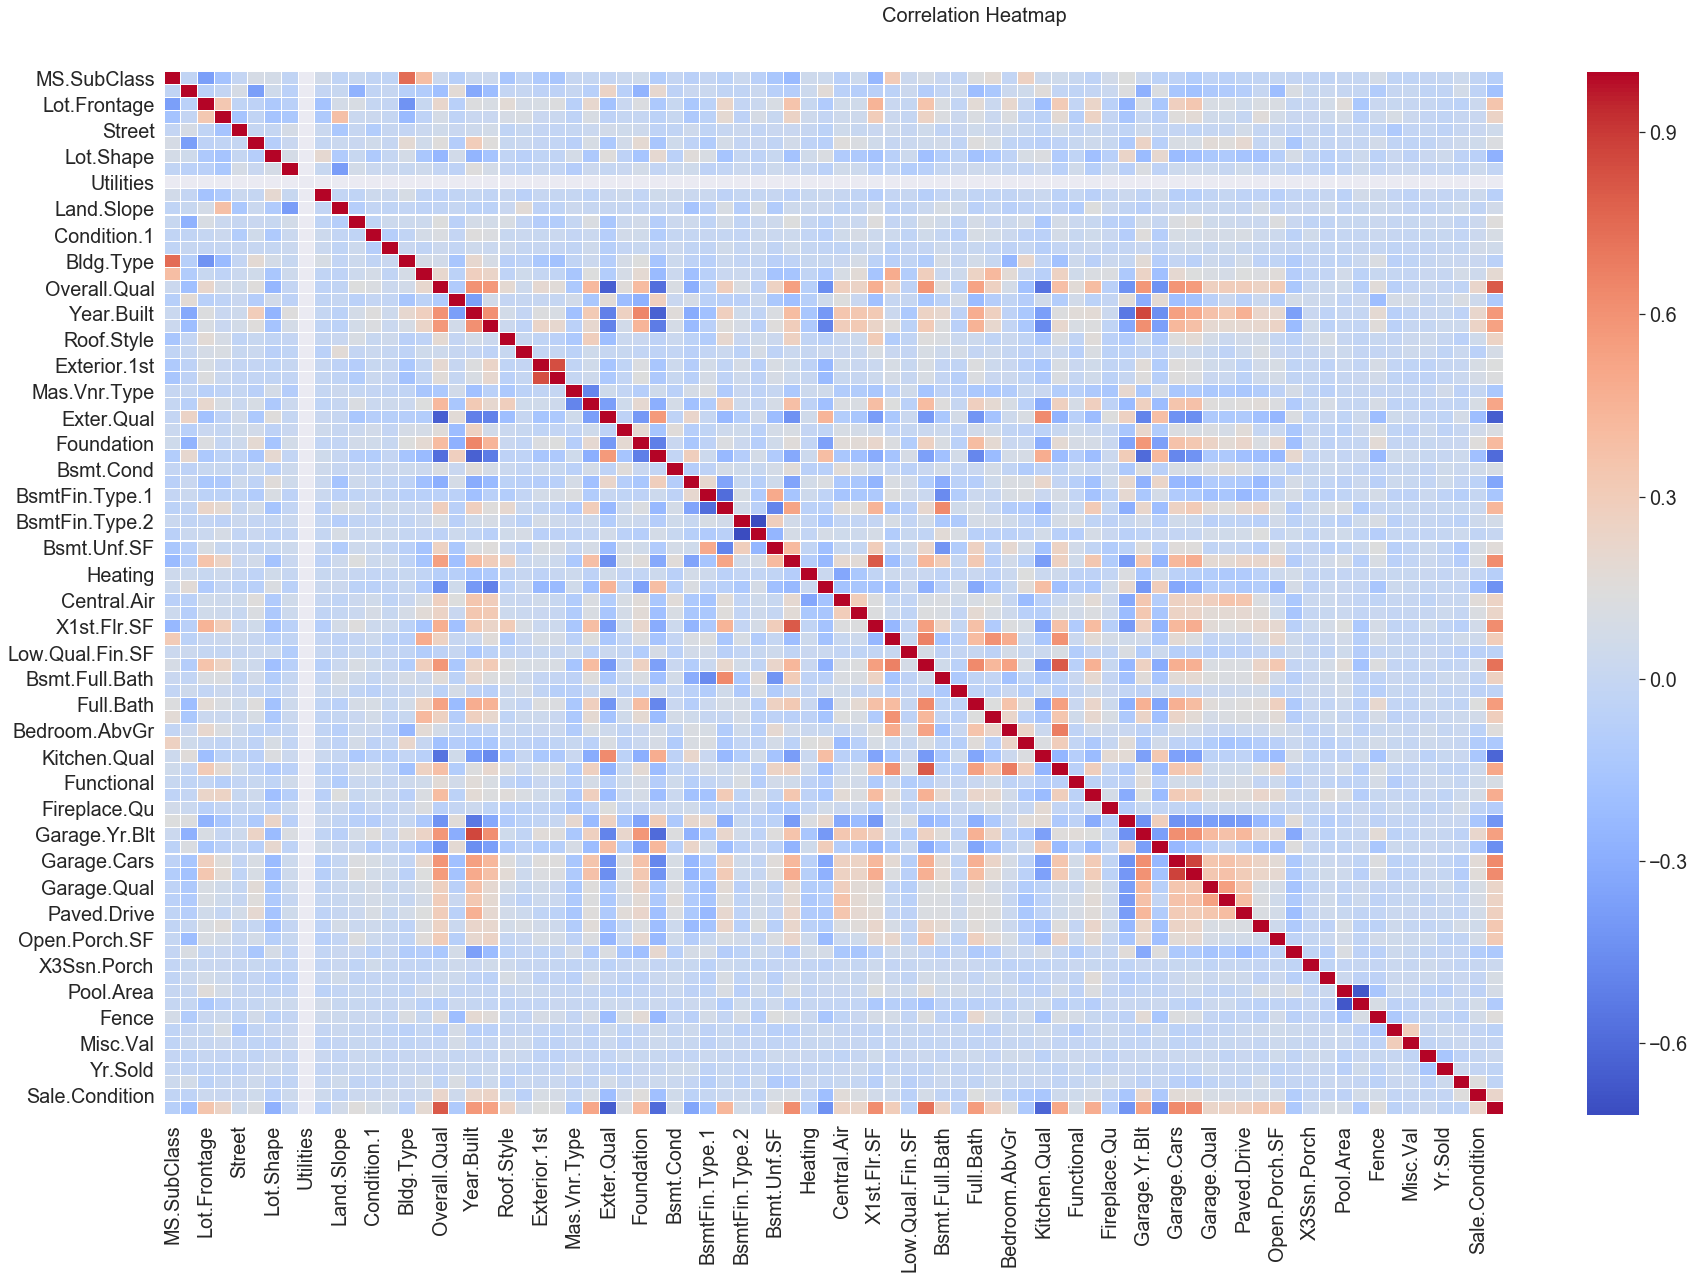

In [36]:
sns.set(style='darkgrid', font_scale=1.8)
fig, ax = plt.subplots(figsize=(30, 18))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm",fmt='.2f',linewidths=.05 )
fig.subplots_adjust(top=0.93)
fig.suptitle('Correlation Heatmap', fontsize=20)
plt.show()

Sprawdzam, które kolumny są najbardziej skorelowane z 'SalePrice', tzn. powyżej 0.50 lub poniżej -0.50

In [37]:
df_most_correlated_cols = pd.DataFrame(df.corr().SalePrice.sort_values())
df_most_correlated_cols = df_most_correlated_cols[df_most_correlated_cols['SalePrice'].between(-0.50, 0.50, inclusive = False) == False]
df_most_correlated_cols

,SalePrice
Exter.Qual,-0.648237
Kitchen.Qual,-0.612648
Bsmt.Qual,-0.593063
TotRms.AbvGrd,0.504280
Mas.Vnr.Area,0.514974
Year.Remod.Add,0.534962
Garage.Yr.Blt,0.541022
Full.Bath,0.561228
Year.Built,0.571716
X1st.Flr.SF,0.619121


Przedmiotem analizy jest przede wszystkim znalezienie korelacji zmiennej 'SalePrice' z innymi zmiennymi. Jednakże na heatmapie można zauważyć szereg innych korelacji, m.in. ogólnego stanu domu ('Overall.Cond) do roku budowy ('Year.Built').

Można zauważyć pozytywną korelację liniową (powyżej 0.50) zmiennej 'SalePrice' ze zmniennymi:
'TotRms.AbvGrd', 'Mas.Vnr.Area', 'Year.Remod.Add', 'Garage.Yr.Blt', 'Full.Bath', 'Year.Built', 'X1st.Flr.SF', 'Total.Bsmt.SF', 'Garage.Area', 'Gr.Liv.Area', 'Overall.Qual' oraz negatywną korelację ze zmiennymi: 'Exter.Qual', 'Kitchen.Qual', 'Bsmt.Qual'. Uwaga - wartości numeryczne dla pól 'Exter.Qual', 'Kitchen.Qual', 'Bsmt.Qual' zostały wcześniej skonwertowane z tekstowych. Im wyższa jakość Quality tym niższy numer w zbiorze danych.

A także słabe negatywne korelacje z pozostałymi zmiennymi. Brak wyraźnej negatywnej korelacji liniowej.
Najsilniejsza jest korelacja ceny 'SalePrice' z 'Gr.Liv.Area', 'Overall.Qual'.

Dla zmiennej 'Utilities' wartość współczynnika korelacji prezentowana jest jako NaN. Wynika to z faktu, że 'Utilities' ma w całym zbiorze tylko jedną wartość, więc trudno mówić o jakiejkolwiek korelacji.

Weryfikuję jak korelacje wyglądają na pairplocie. Dla lepszego zrozumienia korelacji dzielę 'SalePrice' na 4 grupy wg kwantyli.

In [38]:
def priceQuantile(series):
    price25 = series.quantile(0.25)
    price50 = series.quantile(0.50)
    price75 = series.quantile(0.75)

    price_quantile = []
    for value in series:
        if 0 < value < price25:
            price_category = 'very low'
        elif price25 <= value < price50:
            price_category = 'low'
        elif price50 <= value < price75:
            price_category = 'medium'
        else:
            price_category = 'expensive'
        price_quantile.append(price_category)
    return price_quantile

In [39]:
df['SalePriceQuantile'] = priceQuantile(df['SalePrice'])
df['SalePriceQuantile'].head()

0       medium
1     very low
2          low
3     very low
4    expensive
Name: SalePriceQuantile, dtype: object

Dla lepszego przejrzenia pairplot rozdzielam na dwa osobne wykresy.

In [40]:
half = floor(len(df_most_correlated_cols.index)/2)
half

8

In [41]:
series_most_corr = df_most_correlated_cols.index
df_corr1 = df[series_most_corr[:half]]
df_corr2 = df[series_most_corr[half:]]
df_corr1['SalePriceQuantile'] = df['SalePriceQuantile']
df_corr1['SalePrice'] = df['SalePrice']
df_corr2['SalePriceQuantile'] = df['SalePriceQuantile']

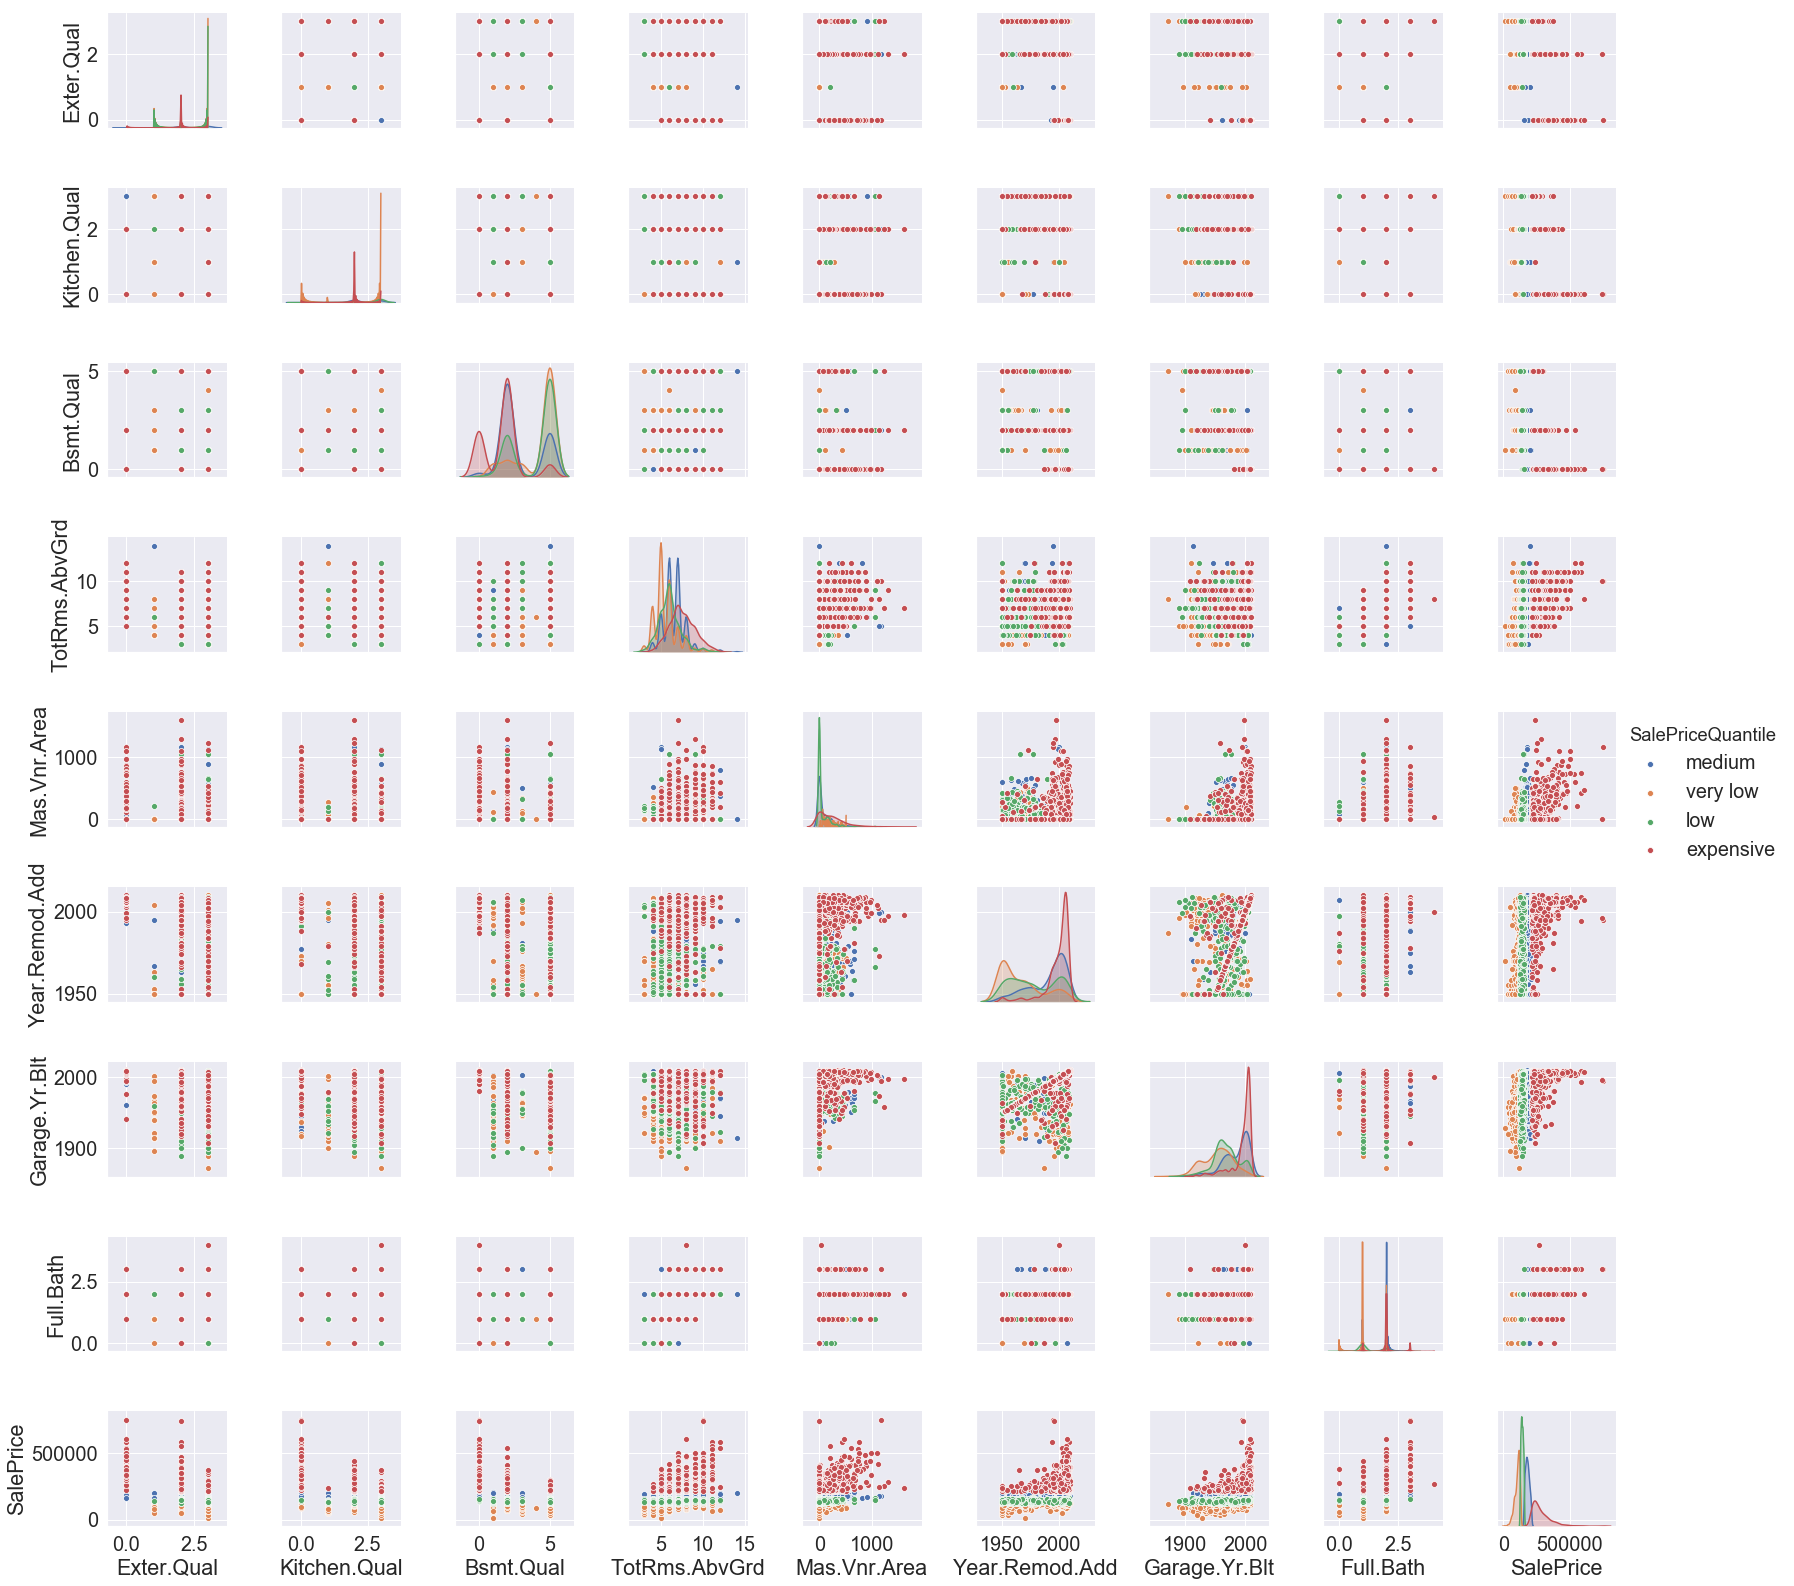

In [42]:
sns.pairplot(data=df_corr1, hue='SalePriceQuantile')
plt.show()

Wnioski dla tej grupy wydają się oczywiste:
- większa liczba pokoi (TotRms.AbvGrd) wpływa na wyższą cenę
- podobnie wielkość działki (Mas.Vnr.Area)
- niedawna modernizacja domu (Year.Remod.Add) również wpływa na wzrost ceny

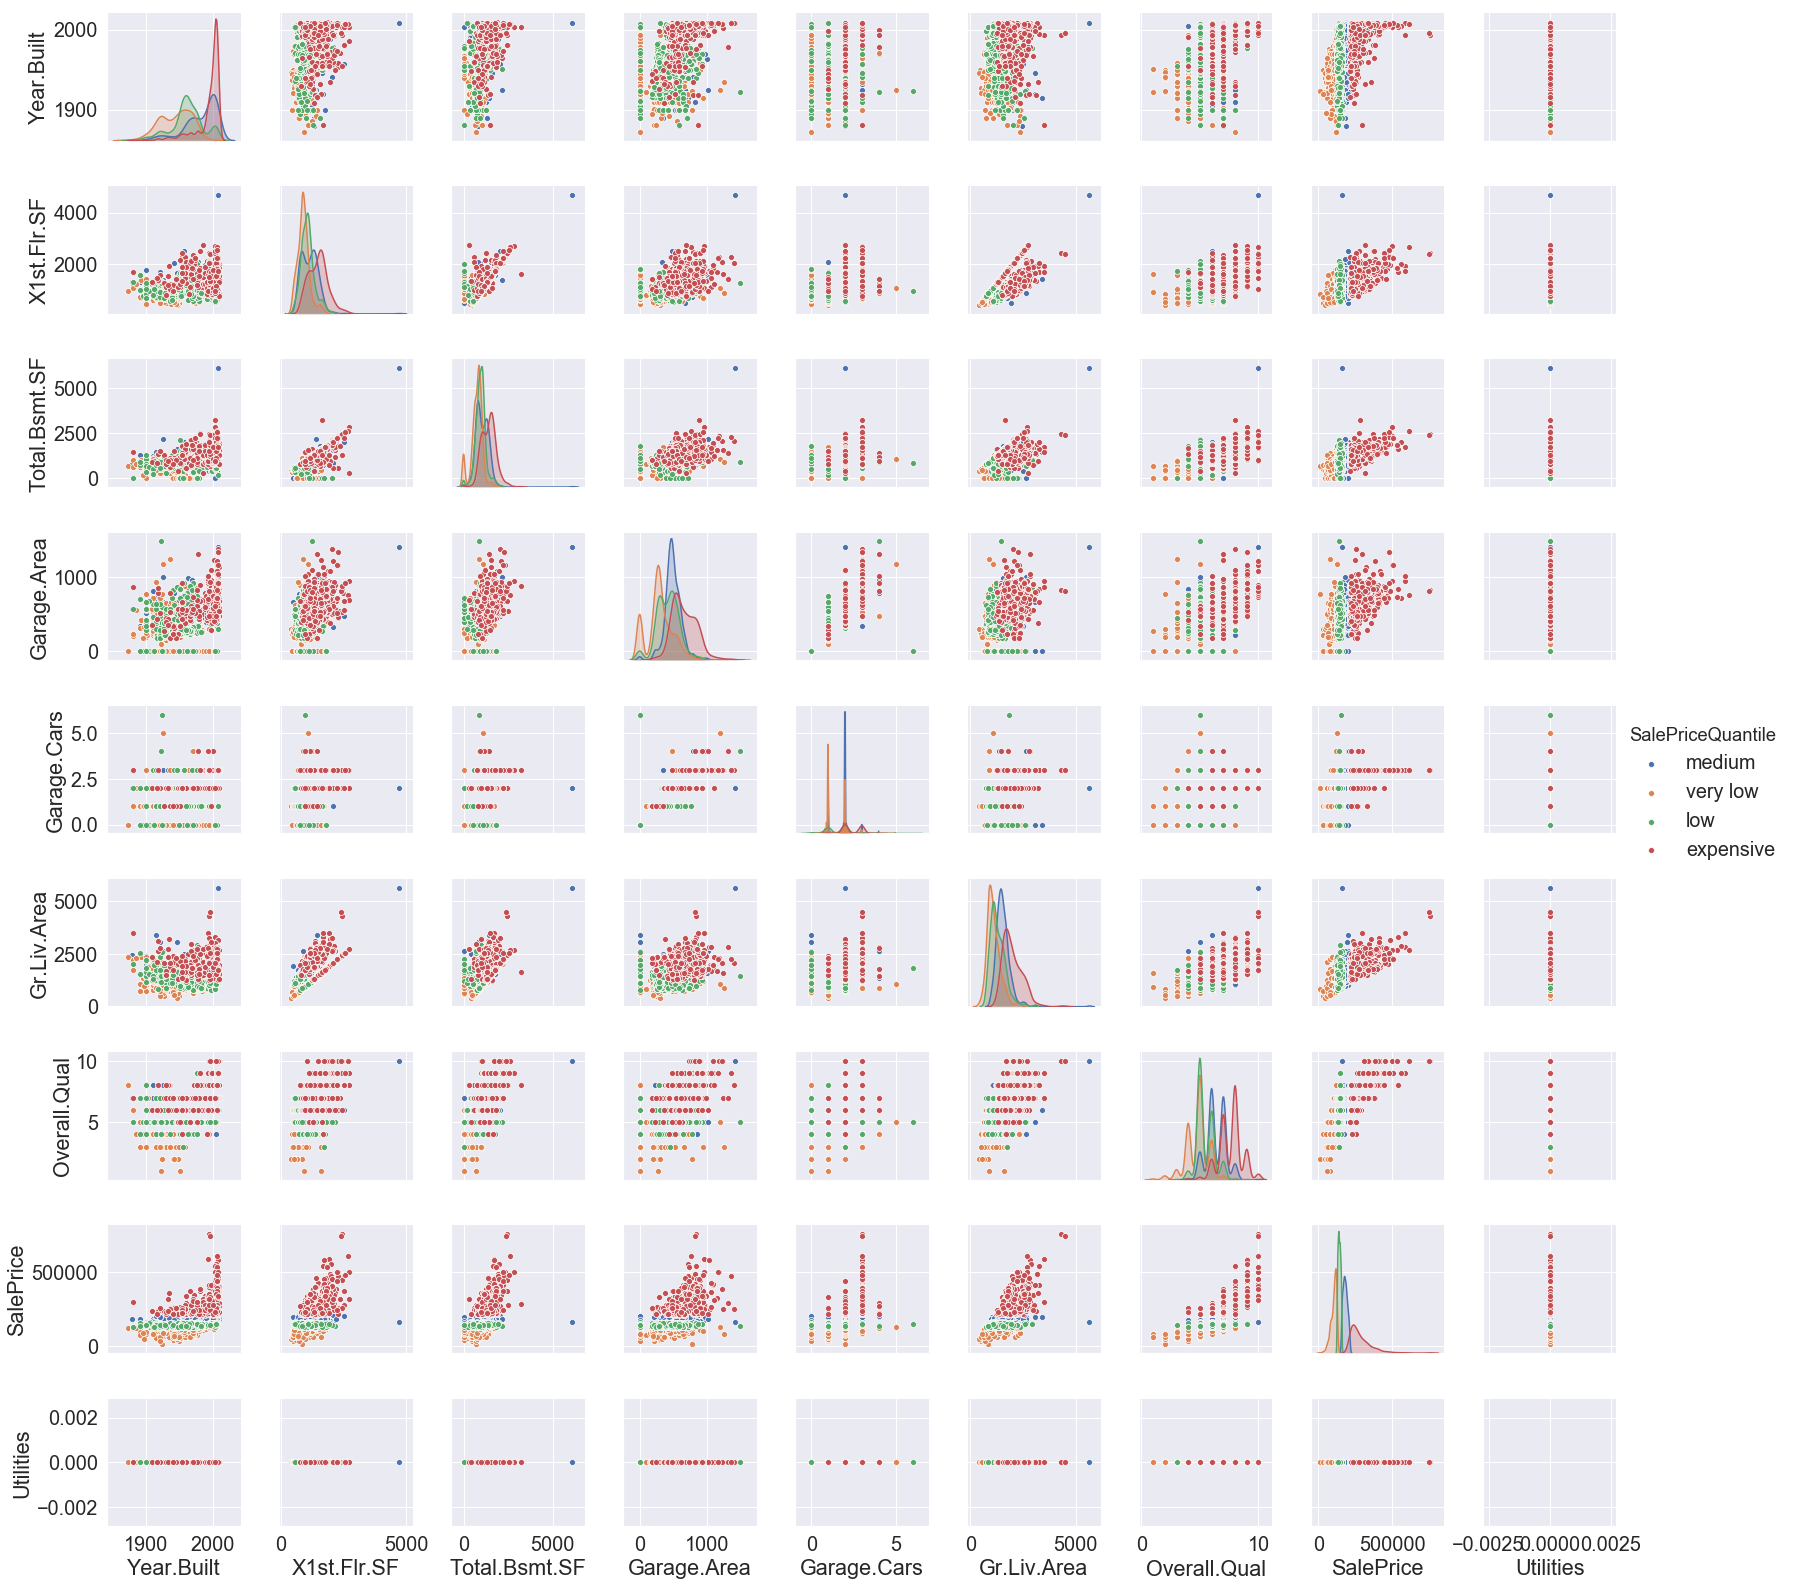

In [43]:
sns.pairplot(data=df_corr2, hue='SalePriceQuantile')
plt.show()

Wnioski:
- starsze domy (Year.Built) mają niższe ceny, natomiast te nowe budowane niedawno znacznie wyższe
- metraż 1 piętra (X1st.Flr.SF) ma wpływ na cenę w podobnym stopniu jak metraż piwnicy(Total.Bsmt.SF) ale oba wyniki różnią się w porównaniu z metrażem garażu (Garage.Area)

### Pozostałe obserwacje

Sprawdzam czy okolica ma znaczenie jeśli chodzi o liczbę sprzedanych domów. Ponieważ kolumna 'Neighborhoods' została już skonwertowana do danych numerycznych, to do wykonania badania wykorzystam kopię danych. 

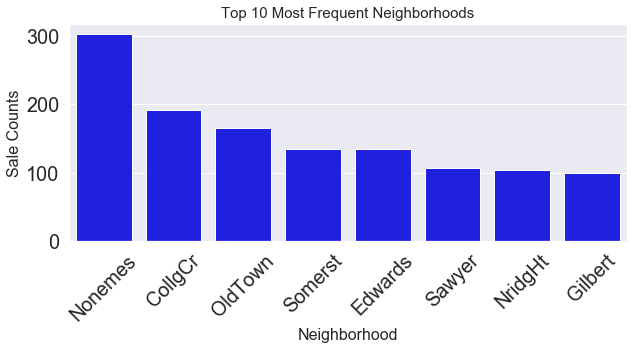

In [44]:
plt.figure(figsize=(10,4))

sns.countplot(x='Neighborhood', data=df_copy, order = df_copy['Neighborhood'].value_counts()[:8].index, color='blue')
plt.title("Top 10 Most Frequent Neighborhoods", fontsize=15) 
plt.xlabel("Neighborhood", fontsize=16)
plt.ylabel("Sale Counts", fontsize=16)
plt.xticks(rotation=45)

sns.set_context(font_scale=2.0) 
plt.show()

Wyraźną popularnością cieszy się okolica Nonemes. 

### Podział zbioru na dane treningowe i testowe

Ponieważ w kolejnych krokach na danych zostaną wykonane pewne przekształcenia oraz uzupełnienia w brakach danych, to na tym etapie nastąpi podział danych na treningowe i testowe.
Przyjmuję podział 70% na train oraz 30% na test. Na wszelki wypadek tworzę kopię zapasową danych.
Ponadto usuwam dane tzw. 'information leaks', tzn dane niosące informację z przyszłości, tj po sprzedaży domu oraz dodaną wcześniej zmienną 'SalePriceQuantile'.

Zmienna 'SalePrice' będzie moją zmienną objaśnianą.

In [45]:
df_train = df.drop(['SalePrice', 'Mo.Sold','Yr.Sold','Sale.Type','Sale.Condition','SalePriceQuantile'], axis=1)
df_test = df['SalePrice']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df_train, df_test, test_size = 0.3, random_state=42)

In [47]:
X_train.head()

,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val
836,160,2,30,3180,1,2,3,3,0,4,0,23,2,2,4,5,7,5,2005,2005,1,1,7,8,3,0,3,3,2,2,5,3,6,0,6,0,600,600,1,0,1,3,520,600,80,1200,0,0,2,1,2,1,2,4,6,0,3,5,2005,2,2,480,5,5,2,0,166,0,0,0,0,3,4,1,0
575,20,5,98,11478,1,1,3,3,0,4,0,18,2,2,0,2,8,5,2007,2008,1,1,11,13,4,200,2,3,2,0,5,3,2,1218,6,0,486,1704,1,0,1,3,1704,0,0,1704,1,0,2,0,3,1,2,7,6,1,2,1,2008,2,3,772,5,5,2,0,50,0,0,0,0,3,4,1,0
557,20,5,69,12160,1,1,0,3,0,4,0,17,2,2,0,2,5,5,1959,1959,3,1,8,10,1,180,3,3,1,5,5,3,5,1000,6,0,188,1188,1,1,1,3,1188,0,0,1188,1,0,1,0,3,1,3,6,6,0,3,1,1959,2,2,531,5,5,2,0,0,0,0,0,0,3,2,1,0
1235,30,6,60,5400,1,1,3,3,0,4,0,19,2,2,0,2,7,6,1920,2006,1,1,10,12,3,0,2,3,1,5,5,3,6,0,6,0,931,931,1,4,1,3,1027,0,0,1027,0,1,1,0,2,1,2,5,6,1,5,6,1920,1,0,0,3,3,0,0,28,0,0,0,0,3,4,1,0
1360,20,5,65,8125,1,1,3,3,0,4,0,17,2,2,0,2,5,7,1959,1959,3,1,7,8,3,0,3,3,1,5,5,3,1,403,6,0,461,864,1,0,1,3,864,0,0,864,0,0,1,0,3,1,3,5,6,0,3,5,1960,3,1,308,5,5,2,0,0,0,0,0,0,3,4,1,0


### Skośność oraz rozkład zbioru

Sprawdzam jak wyglądają różnice między średnią a medianą zbioru - badam skośność.

Współczynnik o wartości 0, to rozkład symetryczny.<br>
Współczynnik o wartości ujemnej to rozkład lewostronnie skośny (wydłużone lewe ramię rozkładu; średnia mniejsza od mediany).<br>
Współczynnik o wartości dodatniej to rozkład prawostronnie skośny (wydłużone prawe ramię rozkładu; średniej większa od mediany).

In [48]:
X_train.skew()

MS.SubClass         1.416002
MS.Zoning          -2.505898
Lot.Frontage        1.739301
Lot.Area           13.692178
Street            -14.050907
Alley              -0.760415
Lot.Shape          -0.658924
Land.Contour       -3.298639
Utilities           0.000000
Lot.Config         -1.176268
Land.Slope          5.061746
Neighborhood       -0.314753
Condition.1         3.081502
Condition.2        11.264628
Bldg.Type           2.260782
House.Style         0.313740
Overall.Qual        0.257339
Overall.Cond        0.599440
Year.Built         -0.572683
Year.Remod.Add     -0.393325
Roof.Style          1.567911
Roof.Matl           7.945474
Exterior.1st       -0.671652
Exterior.2nd       -0.686588
Mas.Vnr.Type       -0.625684
Mas.Vnr.Area        2.491863
Exter.Qual         -1.833387
Exter.Cond         -3.042883
Foundation          0.042806
Bsmt.Qual          -0.215578
Bsmt.Cond          -2.863325
Bsmt.Exposure      -1.157885
BsmtFin.Type.1      0.085933
BsmtFin.SF.1        0.839979
BsmtFin.Type.2

Dla poszczególnych zmiennych można zauważyć rozkłady zarówno lewostronne jak i prawostronne. W szczególności interesuje nas rozkład zmiennej 'SalePrice'. Współczynnik skośności wskazuje że jest to rozkład prawostronnie skośny.

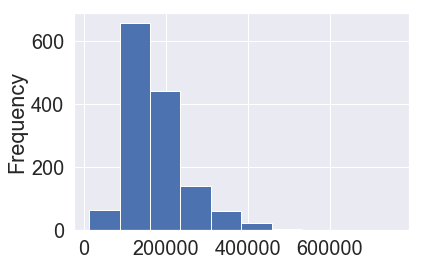

In [49]:
y_train.plot.hist()

Potwierdza to distplot, na którym wyraźnie widać skośność.

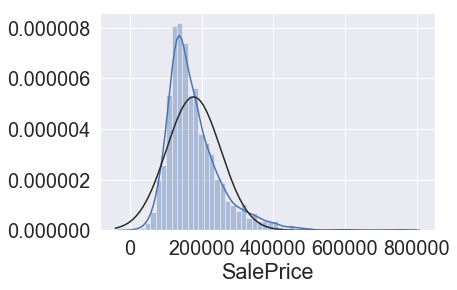

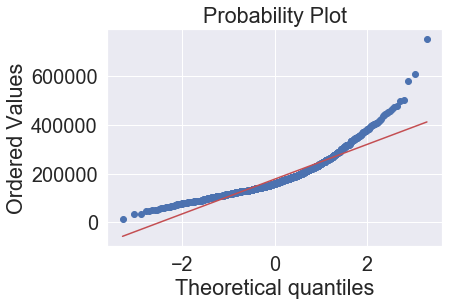

In [50]:
sns.distplot(y_train, fit=stats.norm)
fig = plt.figure()
res = stats.probplot(y_train, plot=plt)

W związku z powyższym w celu uzyskania rozkładu normalnego, skorzystam z logarytmu. Wykonuję transformację.

In [51]:
# y_train = np.log(y_train)

In [52]:
# sns.distplot(y_train, fit=stats.norm)
# fig = plt.figure()
# res = stats.probplot(y_train, plot=plt)

Po wykonaniu transformacji przy użyciu logarytmu, rozkład jest już bardzo zbliżony do normalnego. Również proability plot wygląda lepiej. Końce wykresu nie są już tak odstające od asymptoty.

### Uczenie modeli - porównanie różnych metod regresji

Kolejnym etapem będzie uczenie modeli różnymi metodami. Do wyznaczenia najlepszych parametrów zostanie użyta w każdym przypadku metoda GridSearch.
Uwaga: 
Liczba parametrów param_grid została ograniczona średnio do 3-4. Poniżej pozostawiono kombinacje zawierające najlepsze parametry, nie będące wartościami brzegowymi listy. Przy jednorazowym podaniu większej liczby parametrów, algorytm niestety kończy się błędem 'Memory error' (ograniczenie pamięci komputera autora analizy).     

Do uczenia wykorzystam cross-walidację, dzieląc na 5 foldów.

In [53]:
kfold = model_selection.KFold(n_splits=5, random_state=42)

### Metoda ElasticNet

In [54]:
grid_1 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=1, tol=0.1, random_state=42)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3],
                    'elasticnet__alpha': [0.01, 0.1, 1, 10]},
                    cv=kfold,
                    refit=True)

time_learn_start = time.time()
grid_1.fit(X_train, y_train)
time_learn_stop = time.time()

time_of_learning_1 = time_learn_stop - time_learn_start
grid_1.best_params_

{'elasticnet__alpha': 0.1, 'polynomialfeatures__degree': 1}

### Metoda Lasso

In [55]:
grid_2 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=1, random_state=42)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3],
                    'lasso__alpha': [200, 500, 1000, 5000]},
                    cv=kfold,
                    refit=True)

time_learn_start = time.time()
grid_2.fit(X_train, y_train)
time_learn_stop = time.time()

time_of_learning_2 = time_learn_stop - time_learn_start
grid_2.best_params_

{'lasso__alpha': 500, 'polynomialfeatures__degree': 1}

### Metoda Ridge

In [56]:
grid_3 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1, random_state=42)),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3],
                    'ridge__alpha': [1, 10, 100, 500, 1000]},
                    cv=kfold,
                    refit=True)

time_learn_start = time.time()
grid_3.fit(X_train, y_train)
time_learn_stop = time.time()

time_of_learning_3 = time_learn_stop - time_learn_start
grid_3.best_params_

{'polynomialfeatures__degree': 1, 'ridge__alpha': 100}

### Metoda Linear Regression

In [57]:
grid_4 = GridSearchCV(make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression()),
                    param_grid={'polynomialfeatures__degree': [1, 2, 3],
                               },
                    cv=kfold,
                    refit=True)

time_learn_start = time.time()
grid_4.fit(X_train, y_train)
time_learn_stop = time.time()

time_of_learning_4 = time_learn_stop - time_learn_start
grid_4.best_params_

{'polynomialfeatures__degree': 1}

### Metoda SVR

In [58]:
grid_5 = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=kfold,
                   param_grid={"C": [1e5, 1e6, 1e7, 1e8],
                               "gamma": [0.0001, 0.001, 0.01, 0.1]})

time_learn_start = time.time()
grid_5.fit(X_train, y_train)
time_learn_stop = time.time()

time_of_learning_5 = time_learn_stop - time_learn_start
grid_5.best_params_

{'C': 1000000.0, 'gamma': 0.0001}

### Metoda Random Forest Regressor

In [59]:
param_grid = {
    'n_estimators': [200, 400, 600, 800],
    'max_features': ['auto', 'sqrt', 'log2'], \
}

rfc = RandomForestRegressor(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True, random_state=42) 
grid_6 = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= kfold, refit=True)

time_learn_start = time.time()
grid_6.fit(X_train,y_train)
time_learn_stop = time.time()

time_of_learning_6 = time_learn_stop - time_learn_start
grid_6.best_params_

{'max_features': 'sqrt', 'n_estimators': 600}

### Metoda XGBoost

In [60]:
param_grid = {
    "n_estimators" : [100, 1000, 10000],
    "max_depth" : [5, 7, 9], 
    "learning_rate" : [0.7, 0.8, 0.9]

}

xg_rg = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,  
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

grid_7 = GridSearchCV(estimator=xg_rg, param_grid = param_grid, n_jobs = -1, refit=True)

time_learn_start = time.time()
grid_7.fit(X_train,y_train)
time_learn_stop = time.time()

time_of_learning_7 = time_learn_stop - time_learn_start
grid_7.best_params_

{'learning_rate': 0.7, 'max_depth': 5, 'n_estimators': 100}

### Testowanie modeli - predykcja dla każdego modelu

Etap uczenia został zakończony. Dla każdego modelu znaleziono najlepsze parametry. W kolejnym kroku, dla tych parametrów zostanie wykonana predycja zmiennej 'SalePrice'.
Do oceny, który model jest faktycznie najlepszy posłużą mi metryki:

- r2
- explained_variance_score
- median_absolute_error
- mean_squared_error
- mmean_absolute_error

In [61]:
models = []
models.append(('ElasticNet', grid_1.best_estimator_, time_of_learning_1))
models.append(('Lasso', grid_2.best_estimator_, time_of_learning_2))
models.append(('Ridge', grid_3.best_estimator_, time_of_learning_3))
models.append(('LinearRegression', grid_4.best_estimator_, time_of_learning_4))
models.append(('SVR', grid_5.best_estimator_, time_of_learning_5))
models.append(('RandomForestRegressor', grid_6.best_estimator_, time_of_learning_6))
models.append(('XGBoost', grid_7.best_estimator_, time_of_learning_7))

r2 = []
explained_variance_score = []
median_absolute_error = []
mean_squared_error = []
mean_absolute_error = []
for name, model, time in models:
    r2.append(metrics.r2_score(y_test, model.predict(X_test)))
    explained_variance_score.append(metrics.explained_variance_score(y_test, model.predict(X_test)))
    median_absolute_error.append( metrics.median_absolute_error(y_test, model.predict(X_test)))
    mean_squared_error.append(metrics.mean_squared_error(y_test, model.predict(X_test)))
    mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))

In [62]:
df_models = pd.DataFrame(data=models)
df_models.rename({0 : 'Name', 1 : 'Model', 2 : 'Time_of_learning [s]'}, axis = 1, inplace=True)
df_models.drop(labels=['Model'], axis=1, inplace=True)
df_models.set_index('Name', inplace=True)
df_models['R2'] = r2
df_models['Explained variance score'] = explained_variance_score
df_models['Median absolute error'] = median_absolute_error
df_models['Mean squared error'] = mean_squared_error
df_models['Mean absolute errors'] = mean_absolute_error
df_models

,Time_of_learning [s],R2,Explained variance score,Median absolute error,Mean squared error,Mean absolute errors
Name,,,,,,
ElasticNet,191.799834,0.769051,0.769299,12656.162948,1.635415e+09,19448.954638
Lasso,1576.996684,0.784884,0.785319,12071.031694,1.523299e+09,18801.699975
Ridge,254.954065,0.785749,0.786132,12178.551053,1.517172e+09,18764.312002
LinearRegression,93.250531,0.784052,0.784425,12863.810599,1.529193e+09,18859.824602
SVR,44.510074,0.006553,0.016436,44458.353722,7.034886e+09,59197.627703
RandomForestRegressor,130.873577,0.866847,0.867269,10320.294167,9.428937e+08,17503.005347
XGBoost,168.804271,0.786165,0.786301,16974.070312,1.514230e+09,24302.578145


Najlepszy model to ten, którego R2 oraz wariancja 'Explained variance score' wyszły najbliżej 1. Zatem najlepszym modelem wśród sprawdzanych jest 'RandomForestRegressor'. Ponadto wartości błędów 'Median absolute error', 'Mean squared error', 'Mean absolute errors' są najniższe, co również potwierdza dobry wybór modelu. Jego czas uczenia jest stosunkowo niski.

### Ocena graficzna predykcji modeli

### Porównanie wyników przewidzianych oraz rzeczywistych